In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv( "international-airline-passengers.csv" )
df.tail()

,Month,Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


In [3]:
df[ "Month" ] = pd.to_datetime(df[ "Month" ]) #convert column to datetime
df.set_index( "Month" , inplace= True )
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Text(0, 0.5, 'Passengers')

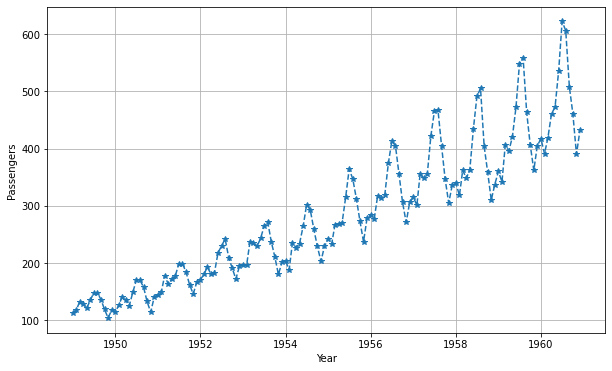

In [4]:
plt.figure(figsize=( 10 , 6 ))
plt.plot(df.index, df.Passengers, '--' , marker= '*' , )
plt.grid()
plt.xlabel( 'Year' )
plt.ylabel( 'Passengers' )

In [5]:
#check for missing values
df.isnull().values.any()

False

In [6]:
#missing values, we will make a copy of our dataset and delete some values at random.
df_copy = df.copy()
rows = df_copy.sample(frac= 0.1 , random_state= 0 )
rows[ 'Passengers' ] = np.nan
df_copy.loc[rows.index, 'Passengers' ] = rows[ 'Passengers' ]
df_copy.isnull().sum()

Passengers    14
dtype: int64

#### There are now 14 missing values in the dataset

In [7]:
#Filling missing data by imputation - Forward fill
df_copy_ffill = df_copy.fillna(method= 'ffill' )
df_copy_ffill.isnull().sum()

Passengers    0
dtype: int64

In [8]:
#Filling missing data by imputation - Backward fill
df_copy_bfill = df_copy.fillna(method= 'bfill' )
df_copy_bfill.isnull().sum() 

Passengers    0
dtype: int64

In [9]:
#Filling missing data by interpolation
df_copy_LIF = df_copy.interpolate(method= 'linear' , limit_direction= 'forward' )
df_copy_LIF.isnull().sum()
#backward
df_copy_LIB = df_copy.interpolate(method= 'linear' , limit_direction= 'backward' )
df_copy_LIB.isnull().sum() 


Passengers    0
dtype: int64

## Downsampling and Upsampling 

In [10]:
#Downsample to quarterly data points
df_quarterly = df.resample( '3M' ).mean()
#Upsample to daily data points
df_daily = df.resample( 'D' ).mean() 

Text(0, 0.5, 'Passengers')

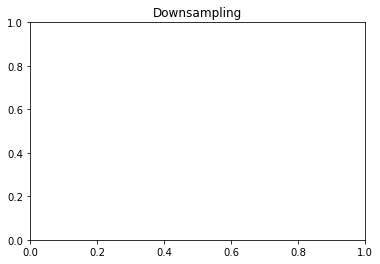

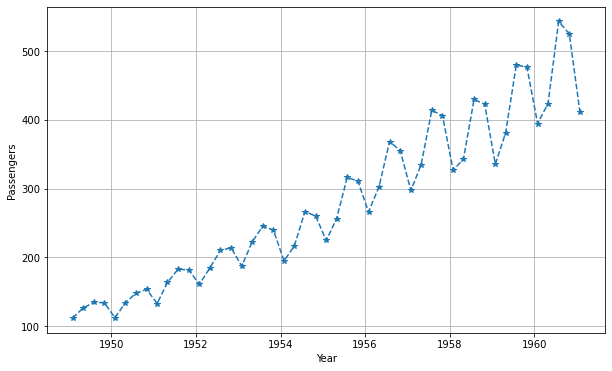

In [11]:
plt.title('Downsampling')
plt.figure(figsize=( 10 , 6 ))
plt.plot(df_quarterly.index, df_quarterly, '--' , marker= '*' , )
plt.grid()
plt.xlabel( 'Year' )
plt.ylabel( 'Passengers' )

In [12]:
df_daily

,Passengers
Month,
1949-01-01,112.0
1949-01-02,NaN
1949-01-03,NaN
1949-01-04,NaN
1949-01-05,NaN
...,...
1960-11-27,NaN
1960-11-28,NaN
1960-11-29,NaN


Text(0, 0.5, 'Passengers')

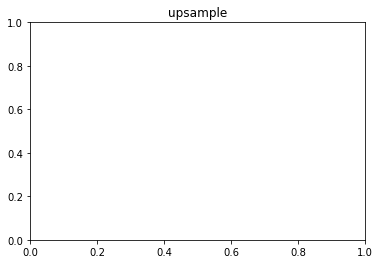

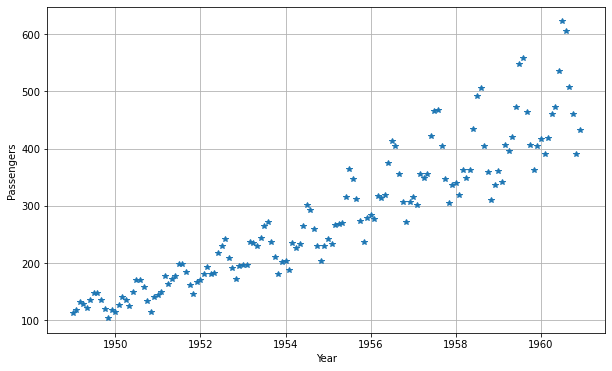

In [13]:
plt.title('upsample')
plt.figure(figsize=( 10 , 6 ))
plt.plot(df_daily.index, df_daily , '--' , marker= '*' , )
plt.grid()
plt.xlabel( 'Year' )
plt.ylabel( 'Passengers' )

In [14]:
df_MA = df.copy()
MA = df_MA[ 'Passengers' ].rolling( 12 ).mean() 

# Time Series Specific Exploratory Methods

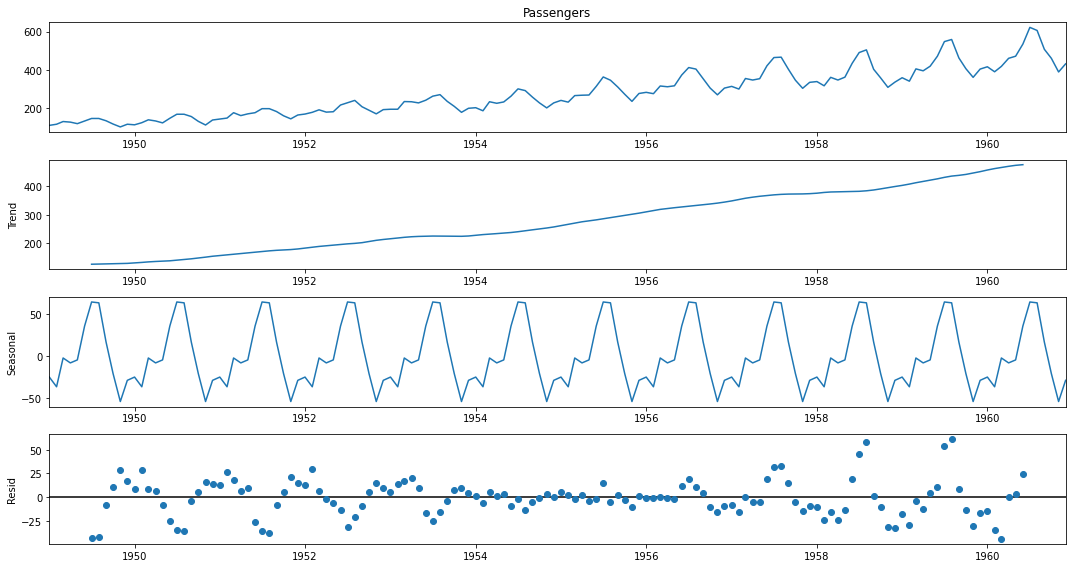

In [15]:
import statsmodels.api as sm
from pylab import rcParams
rcParams[ 'figure.figsize' ] = 15 , 8
decompose_series = sm.tsa.seasonal_decompose(df[ 'Passengers' ], model= 'additive' )
decompose_series.plot()
plt.show() 


### The decomposed time series show an obvious increasing trend and seasonality variations.
Recall that we have initially plotted the moving average on the last 12 months which showed
that it varies with time. This suggests that the data is not stationary. We will now perform
an ADF test to confirm this speculation

In [16]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df[ 'Passengers' ])
print( f'ADF Statistic: {adf_result[ 0 ]} ' )
print( f'p-value: {adf_result[ 1 ]} ' )
print( f'No. of lags used: {adf_result[ 2 ]} ' )
print( f'No. of observations used : {adf_result[ 3 ]} ' )
print( 'Critical Values:' )
for k, v in adf_result[ 4 ].items():
 print( f' {k} : {v} ' ) 


ADF Statistic: 0.8153688792060456 
p-value: 0.991880243437641 
No. of lags used: 13 
No. of observations used : 130 
Critical Values:
 1% : -3.4816817173418295 
 5% : -2.8840418343195267 
 10% : -2.578770059171598 


From the results obtained, the p-value is greater than the critical value at a 5%

significance level and, the ADF statistic is greater that any of the critical valuesobtain. 

This confirms that the series is indeed non-stationary. 

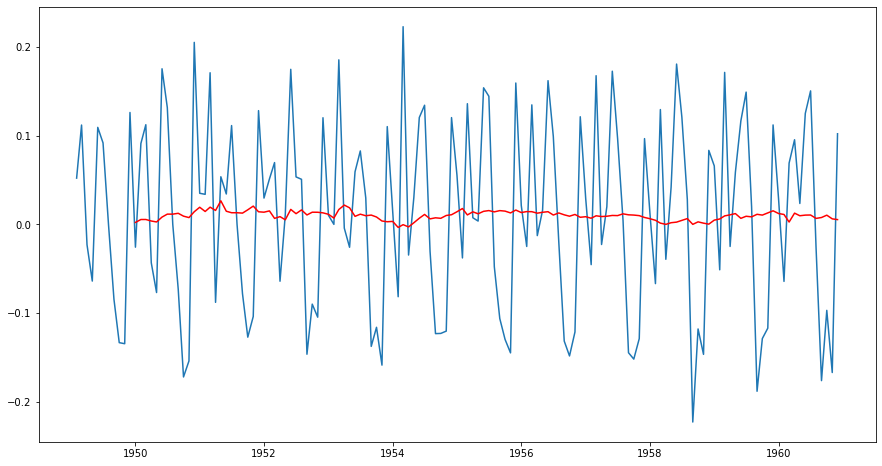

In [17]:
#Convert time series to stationary by removing trend and seasonality
#Transformation and Differencing
df_log = np.log(df)
df_diff = df_log.diff(periods= 1 )
plt.plot(df_diff.index, df_diff.Passengers, '-' )
plt.plot(df_diff.rolling( 12 ).mean(), color= 'red' ) 

## Lesson 4: Time Series Forecasting Using Stochastic Models

In [18]:
df_diff.head()

,Passengers
Month,
1949-01-01,NaN
1949-02-01,0.052186
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022


In [19]:
df_diff.dropna(inplace = True)

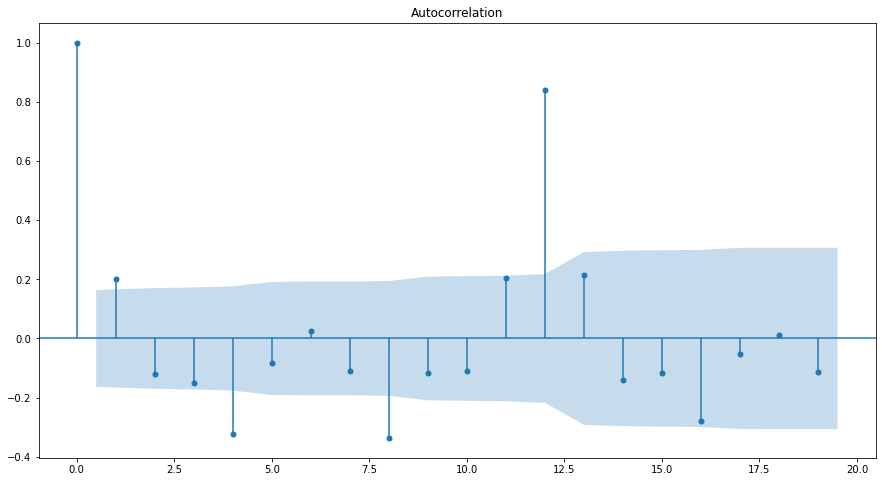

In [20]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df_diff.dropna(), lags = range( 0 , 20 ))
plt.show()
plot_pacf(df_diff.dropna(), lags = range( 0 , 20 ))
plt.show() 


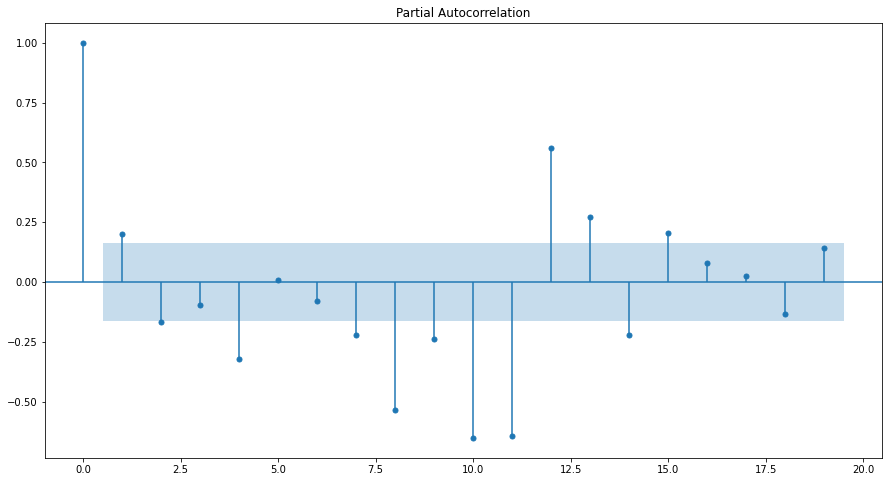

In [21]:
plot_pacf(df_diff.dropna(), lags = range( 0 , 20 ))
plt.show() 


The shaded regions in the plots are the confidence intervals. The lags where the PACF and ACF charts cross this region are the values for p and q respectively. In both plots, #p=q=1.

The shaded regions in the plots are the confidence intervals. The lags where the PACF and ACF charts cross this region are the values for p and q respectively.

In the ACF plot, there is one lag that crosses the significance level hence, q=1. Similarlyin the PACF plot, p=2

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will

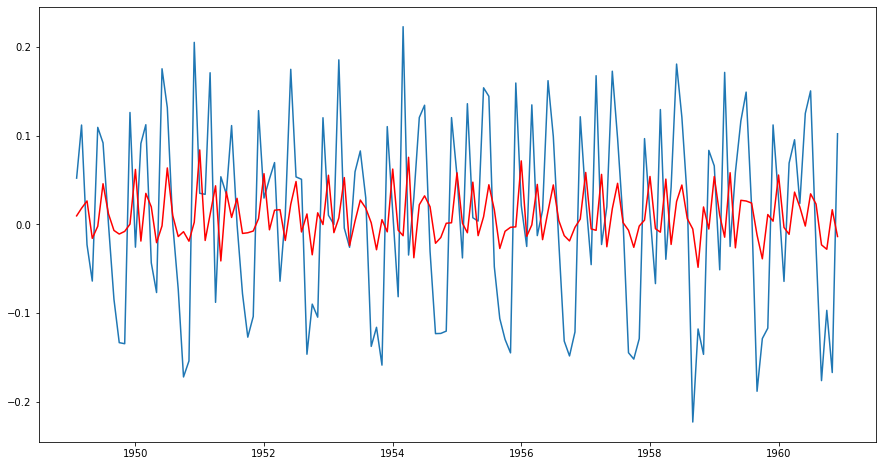

In [22]:
#AR, MA and ARIMA
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
from statsmodels.tsa.arima_model import ARIMA
#(p,d,q)
AR_model = ARIMA(df_diff, order=( 2 , 0 , 0 ))
AR_model_results = AR_model.fit()
plt.plot(df_diff)
plt.plot(AR_model_results.fittedvalues, color= 'red' ) 

In [23]:
AR_model_fit = AR_model.fit(disp=0)
AR_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  143
Model:                     ARMA(2, 0)   Log Likelihood                 122.802
Method:                       css-mle   S.D. of innovations              0.102
Date:                Fri, 30 Sep 2022   AIC                           -237.605
Time:                        16:02:03   BIC                           -225.753
Sample:                    02-01-1949   HQIC                          -232.789
                         - 12-01-1960                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0096      0.009      1.048      0.295      -0.008       0.028
ar.L1.Passengers     0.2359      0.083      2.855      0.004       0.074       0.398
ar.L2.Passengers    -0.1725      0.083     -2.070      0.038      -0.336      -0.009
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6838           -2.3088j            2.4079           -0.2042
AR.2            0.6838           +2.3088j            2.4079            0.2042
-----------------------------------------------------------------------------
"""

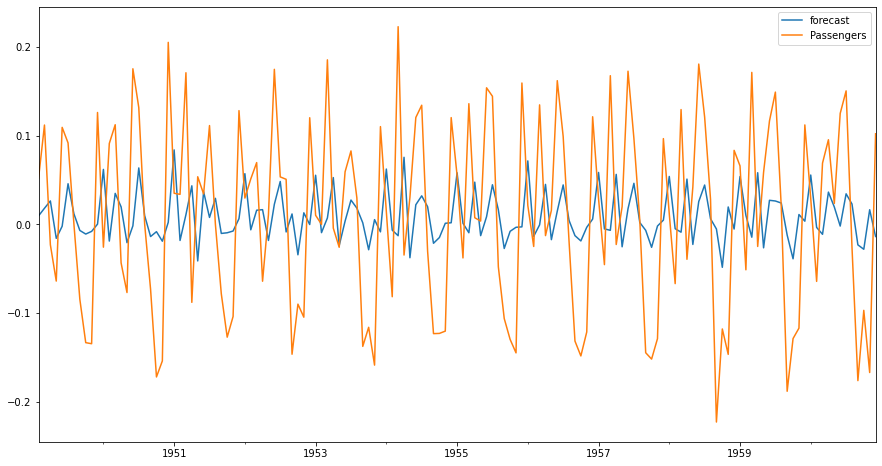

In [24]:
#Here we can see the summary of the model. Let’s predict from the model.

AR_model_fit.plot_predict(dynamic=False)
plt.show()

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will

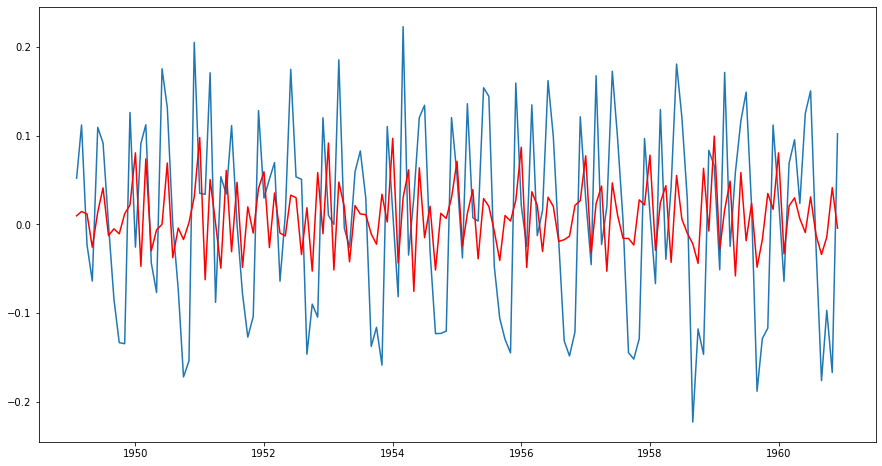

In [25]:
MA_model = ARIMA(df_diff, order=( 0 , 0 , 2 ))
MA_model_results = MA_model.fit()
plt.plot(df_diff)
plt.plot(MA_model_results.fittedvalues, color= 'red' ) 

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


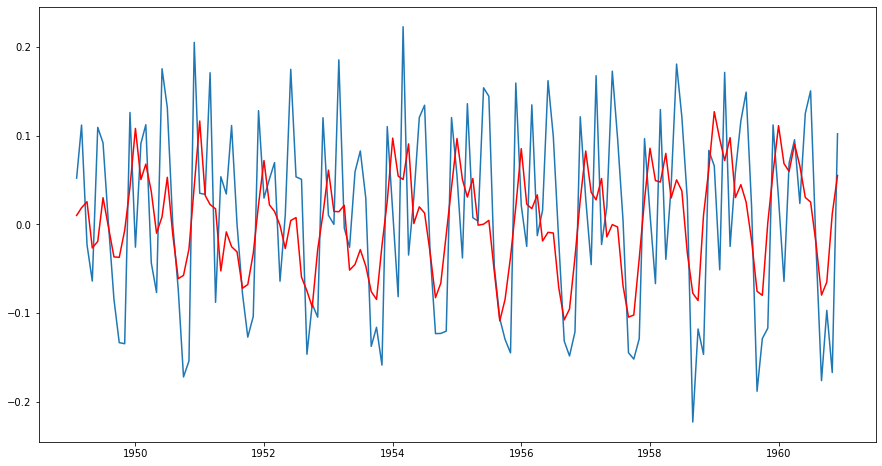

In [26]:
ARIMA_model = ARIMA(df_diff, order=( 2 , 0 , 1 )) 
ARIMA_results = ARIMA_model.fit()
plt.plot(df_diff)
plt.plot(ARIMA_results.fittedvalues, color= 'red' ) 

## ARIMA of the data

In [27]:
model = ARIMA(df.Passengers, order = (1,1,2))
model_fit = model.fit(disp=0)
model_fit.summary()

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.Passengers   No. Observations:                  143
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -680.908
Method:                       css-mle   S.D. of innovations             27.910
Date:                Fri, 30 Sep 2022   AIC                           1371.815
Time:                        16:02:05   BIC                           1386.630
Sample:                    02-01-1949   HQIC                          1377.835
                         - 12-01-1960                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.6527      0.181     14.649      0.000       2.298       3.008
ar.L1.D.Passengers     0.5167      0.098      5.262      0.000       0.324       0.709
ma.L1.D.Passengers    -0.3897      0.121     -3.211      0.001      -0.627      -0.152
ma.L2.D.Passengers    -0.6103      0.120     -5.078      0.000      -0.846      -0.375
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.9354           +0.0000j            1.9354            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.6384           +0.0000j            1.6384            0.5000
-----------------------------------------------------------------------------
"""

### Here we can see the summary of the model. Let’s predict from the model.


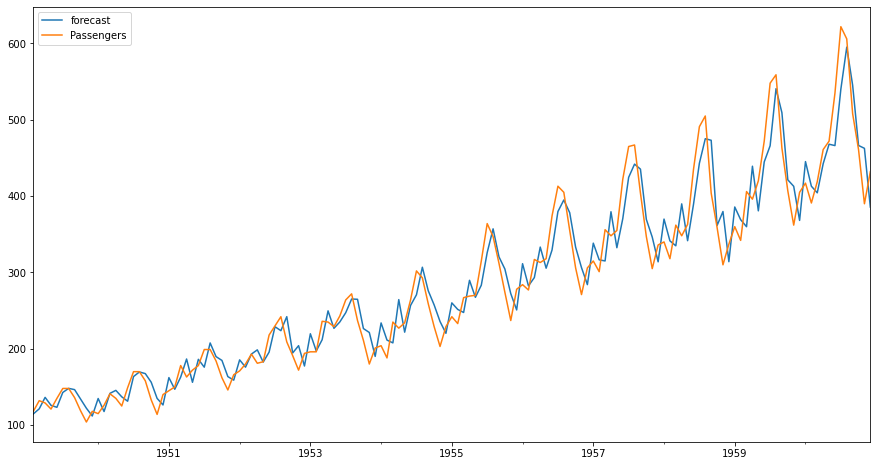

In [28]:
model_fit.plot_predict(dynamic=False)
plt.show()

# Lesson 5: Time Series at Scale
● Time series with Facebook Prophet


In [ ]:
#pip install fbprophet

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from prophet import Prophet

In [4]:
df=pd.read_csv( "international-airline-passengers.csv" )
df.tail()

,Month,Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


In [5]:
df[ 'Month' ]= pd.to_datetime(df[ 'Month' ])
df = df.rename(columns={ "Month" : "ds" , "Passengers" : "y" })
df.head() 

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [8]:
model = Prophet()
model.fit(df) 

21:02:29 - cmdstanpy - INFO - Chain [1] start processing
21:02:59 - cmdstanpy - INFO - Chain [1] done processing
21:02:59 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 3221225657 
Optimization terminated abnormally. Falling back to Newton.
21:02:59 - cmdstanpy - INFO - Chain [1] start processing
21:03:00 - cmdstanpy - INFO - Chain [1] done processing
21:03:01 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 3221225657 


RuntimeError: Error during optimization: 

In [9]:
#predict for the next 10 months
future = model.make_future_dataframe(periods= 10 , freq= 'M' )
forecast = model.predict(future)
forecast.head()
forecast[[ 'ds' , 'yhat' , 'yhat_lower' , 'yhat_upper' , 'trend' , 'trend_lower' , 'trend_upper' ]]
#yhat is the prediction while yhat_lower and yhat_upper are the upper and lower boundaries
model.plot(forecast)
plt.show()

KeyError: 'k'

In [2]:
df = pd.read_csv('Time_series_analysis_and_forecast_DATASET.csv')
df.shape, df.head()

((92016, 5),
               FullDate  Tmax   SysLoad  GasPrice  ElecPrice
 0  2010-09-01 00:00:00  15.8  1688.215      3.69     23.710
 1  2010-09-01 01:00:00  15.8  1669.195      3.69     22.635
 2  2010-09-01 02:00:00  15.8  1491.980      3.69     22.565
 3  2010-09-01 03:00:00  15.8  1330.760      3.69     18.910
 4  2010-09-01 04:00:00  15.8  1247.940      3.69     18.030)

In [3]:
df[ 'FullDate' ]= pd.to_datetime(df[ 'FullDate' ])
df = df.rename(columns={ "FullDate" : "ds" , "ElecPrice" : "y" })
df.head() 

,ds,Tmax,SysLoad,GasPrice,y
0,2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
1,2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2,2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
3,2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
4,2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [4]:
train = df[:2757]
test = df[2757:]

In [5]:
train.head()

,ds,Tmax,SysLoad,GasPrice,y
0,2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
1,2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2,2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
3,2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
4,2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [6]:
train.shape

(2757, 5)

In [7]:
test.tail()

,ds,Tmax,SysLoad,GasPrice,y
92011,2021-02-28 19:00:00,24.3,449.63625,5.4848,117.925
92012,2021-02-28 20:00:00,24.3,815.59975,5.4848,87.880
92013,2021-02-28 21:00:00,24.3,745.12325,5.4848,62.060
92014,2021-02-28 22:00:00,24.3,694.95150,5.4848,62.000
92015,2021-02-28 23:00:00,24.3,714.69630,5.4848,62.955


In [8]:
test.shape

(89259, 5)